In [72]:
%matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy 

FILENAME = 'ticks.csv'
df = pd.read_csv(FILENAME)


Using matplotlib backend: module://matplotlib_inline.backend_inline


In [67]:
#HOW to get grade conversion
pd.options.display.max_rows = 83
print(df[['Rating Code', 'Rating']].sort_values(by='Rating Code').drop_duplicates())

     Rating Code     Rating
623            0  Easy Snow
73           800        3rd
489          900        4th
437          950   Easy 5th
579         1000        5.0
..           ...        ...
127        32250       WI3+
455        32500      WI3-4
458        33000        WI4
456        33250       WI4+
452        33500    WI4-5 X

[82 rows x 2 columns]


In [66]:
## JUPYTER NOTES
# df[ df['Route Type'].str.contains('^TR')] # Filter by regex
# route_types = df['Route Type'].unique() # get unique col values
# df.loc[df['Route Type'].str.contains('Trad') & (df['Rating Code'].between(0, 1500))] # multiple filters (Trad routes & grade)
df.loc[df['Style']=='Solo'].sort_values(by='Date')

Date           37
Route          37
Rating         37
Notes          13
URL            37
Pitches        37
Location       37
Avg Stars      37
Your Stars     37
Style          37
Lead Style      0
Route Type     37
Your Rating     1
Length         36
Rating Code    37
dtype: int64

In [73]:
style_types = ['Lead', 'Solo', 'Flash', 'Send', numpy.nan]
columns = ['Date', 'Rating Code', 'Route Type', 'Pitches', 'Style']
df = df.loc[df['Style'].isin(style_types), columns]
df = df.loc[df['Route Type'].str.contains('Trad|Sport', regex=True)]
df = df.sort_values(by='Date', ascending=True)
df

,Date,Rating Code,Route Type,Pitches,Style
728,2020-09-04,1800,Sport,1,Lead
727,2020-09-05,1600,Sport,1,Lead
725,2020-09-07,1800,Sport,1,NaN
726,2020-09-07,1800,Sport,1,Lead
717,2021-03-27,1600,Sport,1,Lead
...,...,...,...,...,...
5,2024-05-26,2900,Sport,1,Lead
4,2024-05-26,2100,Sport,1,Lead
3,2024-05-26,3400,Sport,1,Lead
2,2024-05-26,3400,Sport,1,Lead


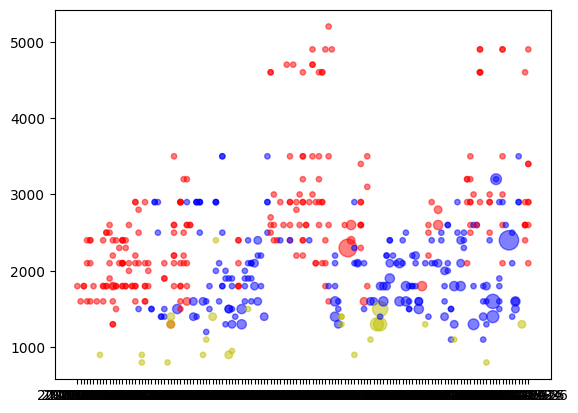

In [80]:
x = df['Date']
y = df['Rating Code']
c = df.apply(lambda x : 'y' if (x['Style'] == 'Solo') else ('r' if (x['Route Type'] == 'Sport') else 'b') , axis=1)
area = (15*df['Pitches'])  
plt.scatter(x, y, c=c, s=area, alpha=0.5) 
plt.savefig('tick_plot.png')
plt.show()

In [40]:
#lambda x : 'y' if (x['Style'] == 'Solo') else ('r' if (x['Route Type'] == 'Sport') else 'Trad')
df.apply(lambda x : 'y' if (x['Style'] == 'Solo') else ('r' if (x['Route Type'] == 'Sport') else 'Trad') , axis=1)


728    r
727    r
725    r
726    r
717    r
      ..
5      r
4      r
3      r
2      r
1      r
Length: 455, dtype: object